In [1]:
import sys
import matplotlib.pyplot as plt
from IPython import display

import torch
import torch.nn as nn

import torchaudio

sys.path.append('../../')

%load_ext autoreload
%autoreload 2
%aimport clarification




In [2]:
%autoreload 2
%aimport clarification

base_dataset_directory = '/workspace/noisy-commonvoice-24k-300ms-10ms-opus/en'

device = "cuda"
sample_rate = 24000
dtype = torch.float32

sample_batch_ms = 300
samples_per_batch = int((sample_batch_ms / 1000) * sample_rate)

overlap_ms = 10
overlap_samples = int((overlap_ms / 1000) * sample_rate)

loader = clarification.datas.commonvoice_loader.CommonVoiceLoader(
    base_dir=base_dataset_directory,
    summary_writer=None,
    dataset_batch_size=8,
    loader_batch_size=4,
    should_pin_memory=device == "cuda",
    num_workers=0,
    device=device
)

loader.create_loaders()

next_input: torch.Size([4, 8, 2, 7200])
next_input: torch.Size([32, 7200])
next_input: torch.Size([230400])


Input max: 0.7535484433174133


next_input: torch.Size([230400])
Clipped audio fft


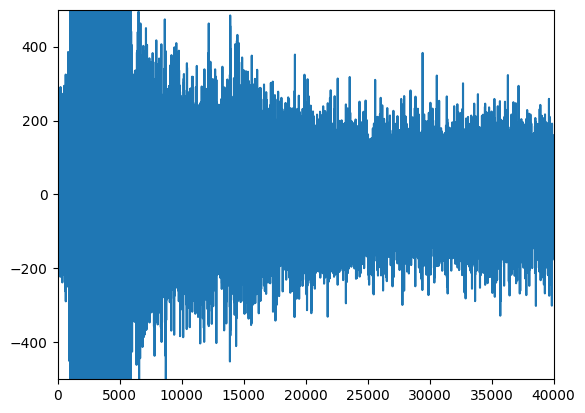

Input audio fft


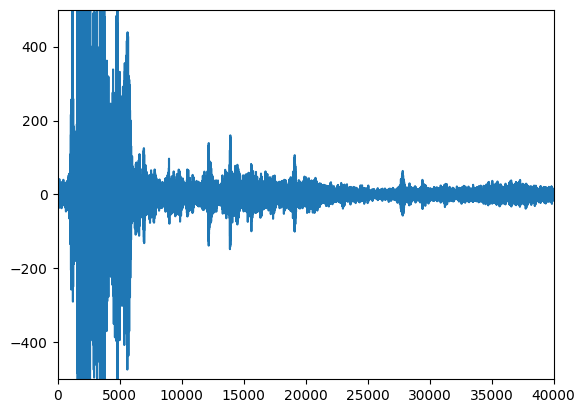

Diff of FFTs


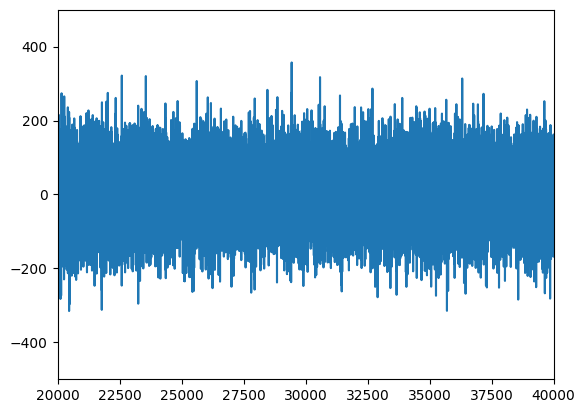

FFT of diff


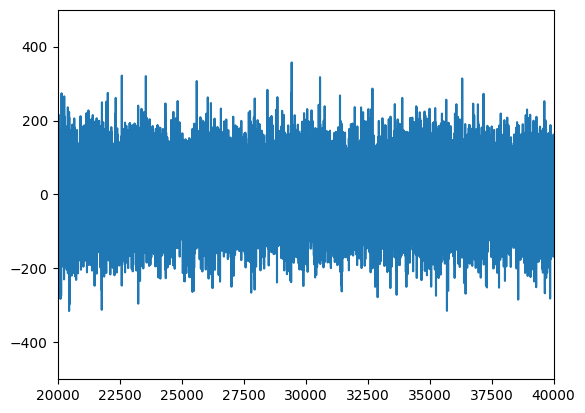

a min: -128


RuntimeError: Class values must be non-negative.

In [122]:
loader_iter = iter(loader.train_loader)

plt.ioff()


next_input = next(loader_iter, None)
print(f"next_input: {next_input.size()}")
next_input = next_input.view(-1, 2, samples_per_batch)
next_input = next_input.squeeze(0).permute(1, 0, 2)[1]

print(f"next_input: {next_input.size()}")
next_input = next_input.reshape(1, next_input.size()[0] * next_input.size()[1]).squeeze(0)
print(f"next_input: {next_input.size()}")
next_input = next_input.to("cpu")

audio_clear_display = display.display("", display_id=True)
audio_clear_display.update(display.Audio(next_input.cpu().detach(), rate=sample_rate))

# audio_louder = torchaudio.transforms.Vol(2)(next_input)

print(f"Input max: {next_input.max()}")

# audio_clipped = torchaudio.transforms.Vol(10)(next_input)
# audio_clipped = torchaudio.transforms.Vol(.5)(next_input)

def noise(audio, stddev=0.1, mean=0):
    noise = torch.randn_like(audio) * stddev + mean

    # Scale noise to -1, 1
    noise = noise / (torch.max(torch.abs(noise)))

    # Add noise to the tensor
    audio_noisy = audio + noise
    
    return audio_noisy
    
# audio_clipped = torch.clamp(next_input, min=-0.2, max=0.1)
audio_clipped = torchaudio.functional.overdrive(next_input, gain=20)
audio_clipped = noise(audio_clipped, stddev=0.1)

audio_clipped_display = display.display("", display_id=True)
audio_clipped_display.update(display.Audio(audio_clipped, rate=sample_rate))

default_ymin = -500
default_ymax = 500

def fft_plot_fft_diff(a, b):
    af = torch.fft.rfft(a)
    bf = torch.fft.rfft(b)
    diff = af - bf
    fig, ax = plt.subplots()
    # ax.set_xlim(0, 10000)
    ax.set_xlim(20000, 40000)
    ax.set_ylim(default_ymin, default_ymax)
    ax.plot(diff)
    return fig, ax

def fft_plot_diff(a, b):
    diff = torch.fft.rfft(a - b)
    fig, ax = plt.subplots()
    ax.set_xlim(20000, 40000)
    ax.set_ylim(default_ymin, default_ymax)
    ax.plot(diff)
    return fig, ax

def plot_normal(a, maxval=None):
    fig, ax = plt.subplots()
    if maxval:
        ax.set_xlim(0, maxval)
    else:
        ax.set_xlim(0, 40000)

    ax.set_ylim(default_ymin, default_ymax)
    ax.plot(a)
    return fig, ax


def plot_vanilla(a):
    fig, ax = plt.subplots()
    ax.plot(a)
    return fig, ax


def clipping_counter(a):
    int64max = torch.iinfo(torch.int64).max
    sizerange = 100
    a = (a * sizerange / 2) + sizerange / 2
    a = a.to(torch.int8).to(torch.int64)
    print(f"a min: {a.min()}")
    b = torch.nn.functional.one_hot(a).sum(dim = 1)

    a_lowres = a.to(torch.int8)

    sample_value_to_count = dict()
    # for idx in range(a):
        
    
    return b

print(f"next_input: {next_input.size()}")

print("Clipped audio fft")
clipped_diff_fig, clipped_diff_ax = plot_normal(torch.fft.rfft(audio_clipped))
d3 = display.display("", display_id=True)
d3.update(clipped_diff_fig)

print("Input audio fft")
normal_fig, normal_ax = plot_normal(torch.fft.rfft(next_input))
d4 = display.display("", display_id=True)
d4.update(normal_fig)

print("Diff of FFTs")
diff_fig, diff_ax = fft_plot_fft_diff(audio_clipped, next_input)
d5 = display.display("", display_id=True)
d5.update(diff_fig)

print("FFT of diff")
diff2_fig, diff2_ax = fft_plot_diff(audio_clipped, next_input)
d5 = display.display("", display_id=True)
d5.update(diff2_fig)


clip_count = clipping_counter(audio_clipped)
print(f"Clipped audio count: {clip_count}")
print(f"Clip count max: {clip_count.max()}")
# fig1, ax1 = plot_vanilla(clip_count)
# d6 = display.display("", display_id=True)
# d6.update(fig1)


# louder_diff_fig, louder_diff_ax = fft_plot_diff(audio_louder, next_input)
# d4 = display.display("", display_id=True)
# d4.update(louder_diff_fig)



plt.close()